In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install fastai torch

In [0]:
from fastai.vision import *

In [0]:
!wget http://files.fast.ai/data/dogscats.zip

In [0]:
!unzip dogscats
!mkdir data
!mv dogscats data/

In [0]:
PATH = "data/dogscats/"
sz = 224
arch = models.resnet34
bs = 64

In [0]:
m = arch(True)

In [0]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
import torch.nn as nn

In [0]:
m1 = nn.Sequential(
                 nn.Conv2d(512, 2, 3, padding = 1),
                 nn.AdaptiveAvgPool2d(1),
                 Flatten(),
                 nn.LogSoftmax())

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip /content/drive/'My Drive'/FastAI_DL_V1/test

In [0]:
data = ImageDataBunch.from_folder(PATH, train= 'train', valid = 'valid', test = '../../test', ds_tfms = get_transforms(), size = 224).normalize(imagenet_stats)

In [0]:
learner = create_cnn(data, arch, pretrained=True, custom_head = m1, cut = -2)
  

In [0]:
learner

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (23000 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/dogscats
x: ImageItemList (23000 items)
[Image (3, 208, 199), Image (3, 330, 499), Image (3, 374, 500), Image (3, 205, 252), Image (3, 375, 499)]...
Path: data/dogscats;

Valid: LabelList
y: CategoryList (2000 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/dogscats
x: ImageItemList (2000 items)
[Image (3, 239, 320), Image (3, 374, 500), Image (3, 500, 497), Image (3, 120, 160), Image (3, 479, 304)]...
Path: data/dogscats;

Test: LabelList
y: CategoryList (12500 items)
[Category dogs, Category dogs, Category dogs, Category dogs, Category dogs]...
Path: data/dogscats
x: ImageItemList (12500 items)
[Image (3, 374, 500), Image (3, 499, 337), Image (3, 364, 399), Image (3, 278, 280), Image (3, 403, 399)]...
Path: data/dogscats, model=Sequential(
  (0): Sequential(
    (0): Conv

In [0]:
learner.freeze_to(-4)

In [18]:
learner.model[-1].training

True

In [20]:
learner.model[0].training

False

In [0]:
len(learner.model) #HEAD (CUSTOM) AND THE BODY (ARCH)

2

In [0]:
learner.lr_find()


epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


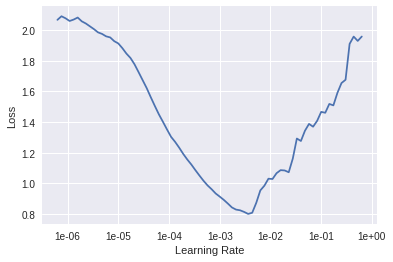

In [0]:
learner.recorder.plot()

In [0]:
learner.fit(1, 0.001)

epoch,train_loss,valid_loss
1,0.175315,0.223032


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [21]:
learner.fit_one_cycle(1, 0.001)

epoch,train_loss,valid_loss
1,0.085736,0.047685


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


**CAM (Class Activation Map)**

In [0]:
class SaveFeatures():
  features = None
  def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
  def hook_fn(self, module , input, output): self.features = output
  def remove(self): self.hook.remove()

In [0]:
x, y = next(iter(data.valid_dl))

In [29]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [0]:
x, y = x[None, 1], y[None, 1]

In [31]:
x.shape, y.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [0]:
from torch.autograd.variable import Variable
vx = Variable(x.cuda(), requires_grad = True)

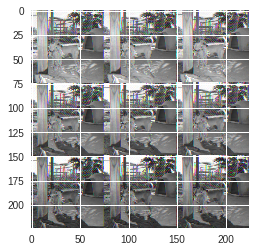

In [47]:
dx = data.denorm(x)[0]
plt.imshow(dx.reshape(dx.shape[1], dx.shape[2], dx.shape[0]))

In [46]:
dx.shape

torch.Size([3, 224, 224])

In [50]:
len(learner.model[0])

8

In [0]:
sfs = [SaveFeatures(o) for o in learner.model[0]]

In [53]:
py = learner.model(Variable(x.cuda()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [54]:
py

tensor([[-2.8994, -0.0566]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [0]:
for o in sfs: o.remove() #removing the hook function since forward gas been called already

In [58]:
[o.features.size() for o in sfs]

[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7])]

In [0]:
py = np.exp(np.array(py)[0])

In [60]:
py

array([0.055057, 0.944943], dtype=float32)

In [0]:
TODO : COMPLETE THE CAM AFTER PART 2 DL